In [1]:
!pip install pydub
!pip install tensorflow_io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 59.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.37.0
    Uninstalling tensorflow-io-gcs-filesystem-0.37.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.37.0


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np

In [3]:
# Load data
version = 3 # just 3 is available
ds = tfds.load(f'speech_commands:0.0.{version}')
train = ds['train']
val = ds['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/85511 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.GK4XFE_0.0.3/speech_commands-train.tfrecord*...…

Generating validation examples...:   0%|          | 0/10102 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.GK4XFE_0.0.3/speech_commands-validation.tfrecor…

Generating test examples...:   0%|          | 0/4890 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.GK4XFE_0.0.3/speech_commands-test.tfrecord*...:…

Dataset speech_commands downloaded and prepared to /root/tensorflow_datasets/speech_commands/0.0.3. Subsequent calls will reuse this data.


In [4]:
#visual class names
info = tfds.builder(f'speech_commands:0.0.{version}').info
class_names = info.features['label'].names
for i,c in enumerate(class_names):
    print(f'{i}: {c}')


0: down
1: go
2: left
3: no
4: off
5: on
6: right
7: stop
8: up
9: yes
10: _silence_
11: _unknown_


In [5]:
#create mel spectrogram using tfio
import tensorflow_io as tfio

def create_mel_spectrogram(audio):
    """
    Create a mel spectrogram from an audio tensor.

    Args:
    audio (tf.Tensor): A 1D tensor containing the audio samples.

    Returns:
    tf.Tensor: A 2D tensor containing the mel spectrogram.
    """

    audio = tf.signal.stft(audio, frame_length=255, frame_step=128)
    audio = tf.abs(audio)
    audio = tfio.audio.melscale(audio, rate=16000, mels=128, fmin=50, fmax=8000)
    audio = tf.math.log(audio + 1e-6)
    audio = tf.transpose(audio)

    return audio

In [6]:
# Preprocess data
def preprocess_data(sample):
    """
    Preprocess a sample from the dataset.

    Args:
    sample (dict): A sample from the dataset.

    Returns:
    tuple: A tuple containing the mel spectrogram and the label.
    """
    audio = sample['audio']
    #convert to float32
    audio = tf.cast(audio, tf.float32)
    #make sure audio is 16000 samples
    audio = audio[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)
    spectrogram = create_mel_spectrogram(audio)
    label = sample['label']
    #make label one-hot
    label = tf.one_hot(label, 12)

    return spectrogram, label

In [7]:
# # Test preprocess_data
# sample = train.take(1)
# sample = sample.map(preprocess_data)

In [19]:
# Create dataset
train_samples = train
train_data = train_samples.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [20]:
print(train)

<_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int16, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [21]:
print(train_data)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, None), dtype=tf.float32, name=None), TensorSpec(shape=(12,), dtype=tf.float32, name=None))>


In [22]:
#batch
train_data = train_data.batch(32)

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(num_classes=12):
    """
    Defines a CNN model for audio classification using mel spectrograms.

    Args:
        num_classes: The number of classes in your classification problem (default is 12).

    Returns:
        A compiled TensorFlow Keras model.
    """
    inputs = layers.Input(shape=(128, 124))

    # Reshape input to 4D tensor
    x = layers.Reshape((128, 124, 1))(inputs)

    # First convolutional block
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Second convolutional block
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Third convolutional block
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten the tensor output from the convolutional blocks
    x = layers.Flatten()(x)

    # Fully connected layers with dropout
    x = layers.Dense(128, activation="relu")(x)
    # x = layers.Dropout(0.5)(x)  # Adjust dropout rate as needed

    # Output layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [24]:
# Build the model
model = build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 124)]        0         
                                                                 
 reshape_1 (Reshape)         (None, 128, 124, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 124, 32)      320       
                                                                 
 batch_normalization_3 (Bat  (None, 128, 124, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 62, 64)        1849

In [25]:
#preprocess validation data
val_samples = val.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_samples = val_samples.batch(32)

In [26]:
# Train the model
history = model.fit(train_data,validation_data= val_samples, epochs=20)  # Adjust epochs as needed

Epoch 1/20
2673/2673 [==============================] - 195s 70ms/step - loss: 1.4102 - accuracy: 0.6417 - val_loss: 1.2418 - val_accuracy: 0.6434
Epoch 2/20
2673/2673 [==============================] - 182s 68ms/step - loss: 1.0112 - accuracy: 0.6865 - val_loss: 0.8606 - val_accuracy: 0.7279
Epoch 3/20
2673/2673 [==============================] - 183s 68ms/step - loss: 0.6918 - accuracy: 0.7707 - val_loss: 0.7481 - val_accuracy: 0.7539
Epoch 4/20
2673/2673 [==============================] - 187s 70ms/step - loss: 0.5119 - accuracy: 0.8259 - val_loss: 0.5306 - val_accuracy: 0.8283
Epoch 5/20
2673/2673 [==============================] - 188s 70ms/step - loss: 0.3605 - accuracy: 0.8786 - val_loss: 0.4751 - val_accuracy: 0.8544
Epoch 6/20
2673/2673 [==============================] - 183s 68ms/step - loss: 0.2702 - accuracy: 0.9130 - val_loss: 0.5113 - val_accuracy: 0.8371
Epoch 7/20
2673/2673 [==============================] - 186s 69ms/step - loss: 0.2126 - accuracy: 0.9313 - val_loss: 0

In [27]:
# Save the model
model.save("audio_classifier.keras")

In [28]:
# Load the model
model = tf.keras.models.load_model("audio_classifier.keras")

In [30]:
# Test the model
test = ds['test']
test_samples = test
test_data = test_samples.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data = test_data.batch(32)
model.evaluate(test_data)


153/153 [==============================] - 9s 51ms/step - loss: 1.7611 - accuracy: 0.8025


[1.7610950469970703, 0.8024539947509766]

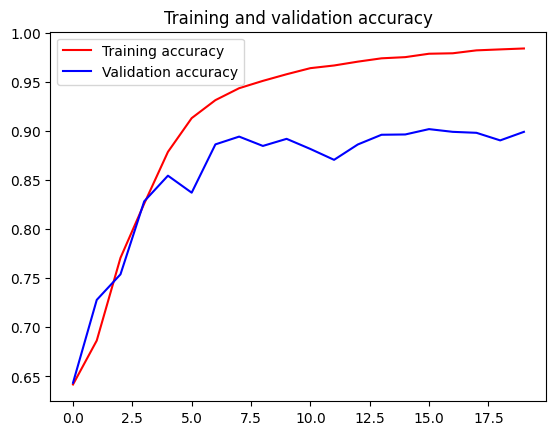

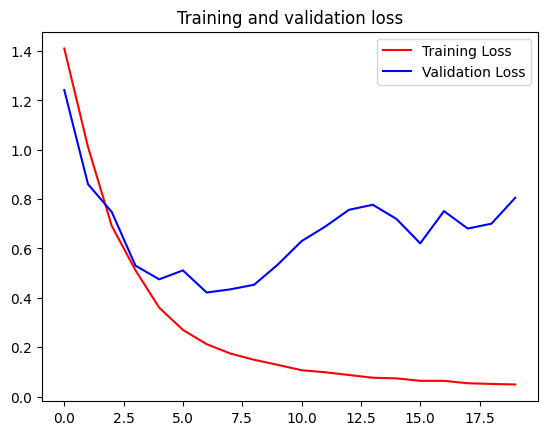

In [32]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.clf()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()